<a href="https://colab.research.google.com/github/Mahammed400/Goruntu-isleme/blob/main/YZU_FINAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Kütüphanelerin Yüklenmesi
!pip install tensorflow
!pip install keras
!pip install optuna
import os
import numpy as np
import optuna
import time
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, Callback
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Model
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 11.3 MB/s eta 0:00:00


In [ ]:
import os
# Klasör yolunu belirtin
data_folder = '/content/Dataset org'

# Klasör içindeki dosyaları listele
file_list = os.listdir(data_folder)

# Dosya listesini gösterin
print("Klasördeki dosyalar:")
for file_name in file_list:
    print(file_name)

def count_images_in_folder(folder_path):
    total_images = 0
    for root, dirs, files in os.walk(folder_path):
        for dir in dirs:
            subdir_path = os.path.join(root, dir)
            image_files = [f for f in os.listdir(subdir_path) if f.endswith(('.jpg', '.png'))]
            print(f"{dir}: {len(image_files)} resim")
            total_images += len(image_files)
    print(f"Toplam {total_images} resim")

# Train klasörü için resim sayısını hesapla
train_folder = os.path.join(data_folder, 'train')
print("\nTrain klasöründeki resim sayısı:")
count_images_in_folder(train_folder)

# Test klasörü için resim sayısını hesapla
test_folder = os.path.join(data_folder, 'test')
print("\nTest klasöründeki resim sayısı:")
count_images_in_folder(test_folder)


Klasördeki dosyalar:
train
test

Train klasöründeki resim sayısı:
cars: 987 resim
ship: 1000 resim
airplanes: 997 resim
Toplam 2984 resim

Test klasöründeki resim sayısı:
cars: 182 resim
airplanes: 178 resim
ships: 200 resim
Toplam 560 resim


Gösterilen resim: /content/Dataset org/train/cars/cars120.jpg


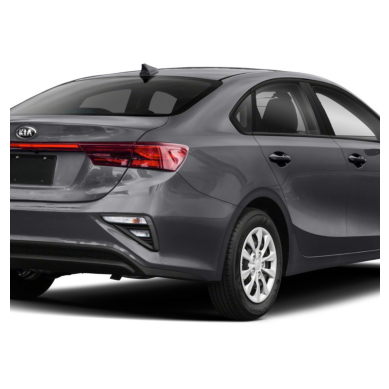

Gösterilen resim: /content/Dataset org/train/ship/1097264.jpg


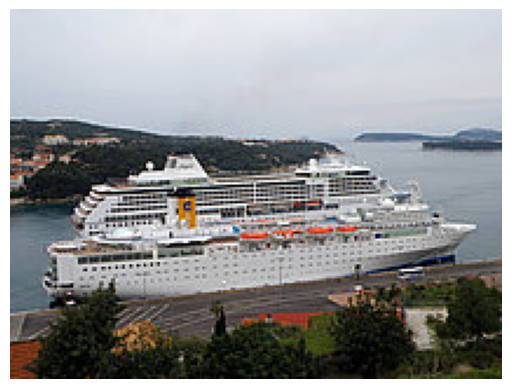

Gösterilen resim: /content/Dataset org/train/airplanes/airplane13.jpg


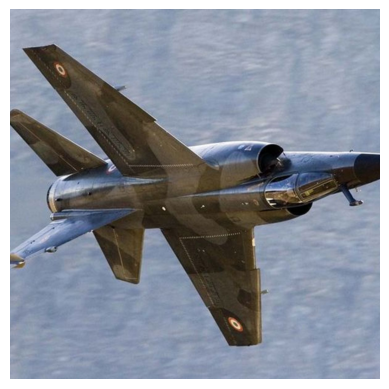

Gösterilen resim: /content/Dataset org/test/cars/cars134.jpg


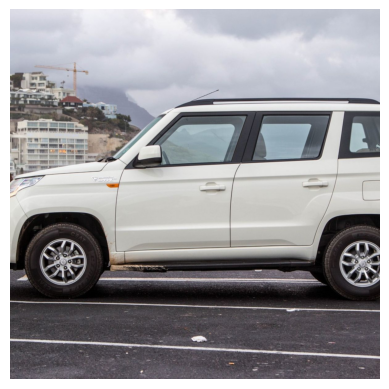

Gösterilen resim: /content/Dataset org/test/airplanes/airplane130.jpg


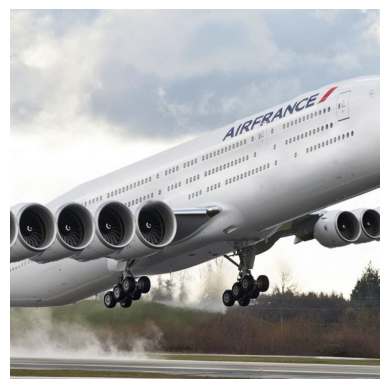

Gösterilen resim: /content/Dataset org/test/ships/2147837.jpg


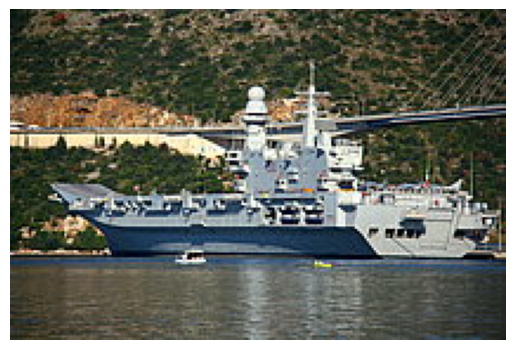

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt


def show_specific_image(folder_path, index=34):  # 35. resim için indeks 34
    subfolders = [d for d in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, d))]
    for subdir in subfolders:
        subdir_path = os.path.join(folder_path, subdir)
        image_files = [f for f in os.listdir(subdir_path) if f.endswith(('.jpg', '.png'))]
        if len(image_files) > index:
            image_path = os.path.join(subdir_path, sorted(image_files)[index])
            print(f"Gösterilen resim: {image_path}")
            image = Image.open(image_path)
            plt.imshow(image)
            plt.axis('off')
            plt.show()
        else:
            print(f"{subdir_path} alt klasöründe yeterli sayıda resim yok. Toplam resim sayısı: {len(image_files)}")

# Train ve Test klasörleri için fonksiyonu çağır

train_folder = os.path.join(data_folder, 'train')
test_folder = os.path.join(data_folder, 'test')

show_specific_image(train_folder)  # train klasöründeki her bir alt klasör için 35. resmi göster
show_specific_image(test_folder)  # test klasöründeki her bir alt klasör için 35. resmi göster

# Ek olarak test/airplanes alt klasöründeki 35. resmi göster
test_airplanes_folder = os.path.join(test_folder, 'airplanes')
show_specific_image(test_airplanes_folder)  # test/airplanes klasöründeki 35. resmi göster


In [ ]:
# Veri Klasörlerinin Tanımlanması
train_folder = os.path.join(data_folder, 'train')
test_folder = os.path.join(data_folder, 'test')

In [ ]:
#CNN
def create_model(trial):
    # Katman sayısını belirlemek  Modeldeki katman sayısını belirlemek için n_layers adında bir değişken oluşturuluyor.
    n_layers = trial.suggest_int('n_layers', 1, 3)

    # Modeli başlat
    model = Sequential()

    # İlk katmanı ekle (giriş katmanı da dahil)
    model.add(Conv2D(trial.suggest_categorical('filters_first', [16, 32, 64]),#Giriş katmanı oluşturuluyor. Bu katman, 64x64 piksel boyutunda ve 3 kanallı (RGB) görüntüler alacak şekilde ayarlanıyor.
                     kernel_size=3,# evrişim katmanlarında kullanılacak olan çekirdeklerin 3x3 boyutunda olduğunu belirtir.
                     activation='relu',#İlk evrişim katmanı ekleniyor. Bu katman, belirli bir filtre sayısına ve ReLU aktivasyon fonksiyonuna sahip olacak şekilde Optuna tarafından seçiliyor.
                     input_shape=(64, 64, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2))) #MaxPooling2D katmanı ekleniyor. Bu, evrişim işleminin boyutunu azaltmaya yardımcı olan bir katmandır.

    # Ek katmanlar ekle n_layers değişkeninde belirlenen sayıda ek evrişim katmanı ve MaxPooling katmanı ekleniyor
    for i in range(n_layers):
        model.add(Conv2D(trial.suggest_categorical(f'filters_layer_{i+1}', [16, 32, 64]),
                         kernel_size=3,
                         activation='relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))

    # Düzleştirme katmanı  evrişimli katmanlardan gelen çıktıları tek boyutlu bir vektöre dönüştürüyor.
    model.add(Flatten())
    # Tam bağlantılı katman
    model.add(Dense(trial.suggest_categorical('units', [64, 128, 256]), activation='relu'))
    # Çıkış katmanı
    model.add(Dense(3, activation='softmax'))  # 3 sınıf
    # Modeli derle
    model.compile(optimizer=trial.suggest_categorical('optimizer', ['adam', 'rmsprop']),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model


In [ ]:


class TimeHistory(Callback):
    def on_train_begin(self, logs=None):
        self.times = []  # Her epoch için süreleri saklar
        self.total_time = 0  # Toplam süreyi saklar
        self.start_time = time.time()  # Eğitim başlangıç zamanı

    def on_epoch_begin(self, epoch, logs=None):
        self.epoch_start_time = time.time()  # Epoch başlangıç zamanı

    def on_epoch_end(self, epoch, logs=None):
        epoch_time = time.time() - self.epoch_start_time
        self.times.append(epoch_time)
        self.total_time += epoch_time  # Toplam süreye ekler
        print(f"Epoch {epoch + 1} ---- {int(epoch_time // 60)} dakika {int(epoch_time % 60)} saniye")

    def on_train_end(self, logs=None):
        # Eğitim sonunda toplam süreyi yazdır
        total_minutes = int(self.total_time // 60)
        total_seconds = int(self.total_time % 60)
        print(f"Toplam Eğitim Süresi: {total_minutes} dakika {total_seconds} saniye")

#Objective adında bir fonksiyon tanımlanır ve bu fonksiyon bir trial parametresi alır.
#Veri artırma işlemi için ImageDataGenerator nesneleri oluşturulur.
def objective(trial):
    model = create_model(trial)
    train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True,
                                       validation_split=0.2) # %20 doğrulama için ayrılıyor

    # Eğitim ve doğrulama veri setleri
    train_generator = train_datagen.flow_from_directory( # belirli bir dizinden görüntü veri yüklemeyi sağliyor
        train_folder,
        target_size=(64, 64), #veri setini verilen boyuta yeniden boyutlandırır
        batch_size=32,
        class_mode='categorical',
        subset='training'
    )
 #Doğrulama veri seti için de aynı işlemler yapılır.
    validation_generator = train_datagen.flow_from_directory(
        train_folder,
        target_size=(64, 64),
        batch_size=32,
        class_mode='categorical',
        subset='validation'#parametresi kullanılarak doğrulama için ayrılmış olan veri seti yüklenir
    )

    # Early stopping ve zaman takibi callback'leri.Early belirli bir sabır (patience) değerine ulaşıldığında eğitimi durdurur ve en iyi model ağırlıklarını geri yükler.
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True) #En iyi ağırlıkları geri yükleyin.
    time_history = TimeHistory() #  verbose Geri çağrının çıktısı. Değer 1 ise, her durumda bir mesaj yazdırır; 0 ise sessiz kalır.

    # Model eğitimi
    history = model.fit(
        train_generator,
        epochs=50,
        validation_data=validation_generator,
        callbacks=[early_stopping, time_history],
        verbose=0
    )
    #n_trials parametresi, deneme sayısını belirtir, yani kaç farklı hiperparametre kombinasyonu denenmesi gerektiğini belirler.
    # En iyi epoch ve doğruluk bilgisini döndür
    best_epoch = early_stopping.stopped_epoch - 3  # Early stopping 3 sabrından dolayı
    print(f"En iyi epoch: {best_epoch + 1} ile en iyi doğruluk.")
    validation_accuracy = history.history['val_accuracy'][best_epoch]
    return validation_accuracy

# Optuna çalıştırma
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=2)

# En iyi parametrelerin yazdırılması
print("En iyi parametreler:", study.best_trial.params)


[I 2024-05-05 17:42:04,146] A new study created in memory with name: no-name-832889c1-27dc-41db-bdad-b32eee60ac9c


Found 2400 images belonging to 3 classes.
Found 600 images belonging to 3 classes.
Epoch 1 ---- 0 dakika 41 saniye
Epoch 2 ---- 0 dakika 35 saniye
Epoch 3 ---- 0 dakika 38 saniye
Epoch 4 ---- 0 dakika 40 saniye
Epoch 5 ---- 0 dakika 33 saniye
Epoch 6 ---- 0 dakika 33 saniye
Epoch 7 ---- 0 dakika 35 saniye
Restoring model weights from the end of the best epoch: 5.
Epoch 8 ---- 0 dakika 42 saniye
Epoch 8: early stopping


[I 2024-05-05 17:47:07,111] Trial 0 finished with value: 0.8550000190734863 and parameters: {'n_layers': 1, 'filters_first': 32, 'filters_layer_1': 32, 'units': 256, 'optimizer': 'adam'}. Best is trial 0 with value: 0.8550000190734863.


Toplam Eğitim Süresi: 5 dakika 2 saniye
En iyi epoch: 5 ile en iyi doğruluk.
Found 2400 images belonging to 3 classes.
Found 600 images belonging to 3 classes.
Epoch 1 ---- 0 dakika 46 saniye
Epoch 2 ---- 0 dakika 43 saniye
Epoch 3 ---- 0 dakika 42 saniye
Epoch 4 ---- 0 dakika 42 saniye
Epoch 5 ---- 0 dakika 45 saniye
Epoch 6 ---- 0 dakika 43 saniye
Epoch 7 ---- 0 dakika 42 saniye
Epoch 8 ---- 0 dakika 44 saniye
Epoch 9 ---- 0 dakika 42 saniye
Epoch 10 ---- 0 dakika 43 saniye
Epoch 11 ---- 0 dakika 40 saniye
Epoch 12 ---- 0 dakika 44 saniye
Restoring model weights from the end of the best epoch: 10.
Epoch 13 ---- 0 dakika 44 saniye
Epoch 13: early stopping


[I 2024-05-05 17:56:34,248] Trial 1 finished with value: 0.8600000143051147 and parameters: {'n_layers': 2, 'filters_first': 64, 'filters_layer_1': 32, 'filters_layer_2': 64, 'units': 256, 'optimizer': 'adam'}. Best is trial 1 with value: 0.8600000143051147.


Toplam Eğitim Süresi: 9 dakika 25 saniye
En iyi epoch: 10 ile en iyi doğruluk.
En iyi parametreler: {'n_layers': 2, 'filters_first': 64, 'filters_layer_1': 32, 'filters_layer_2': 64, 'units': 256, 'optimizer': 'adam'}


In [ ]:
# YENI CNN MODELI
# fonksiyon tanımlanır ve bu fonksiyon, bir dizi hiperparametre değeri olan params parametresini alır.
# Bu parametre, önceki optimizasyon sürecinden elde edilen en iyi hiperparametre değerlerini içerir.
def create_model_from_best_params(params):
    model = Sequential()
    model.add(Conv2D(params['filters_first'], kernel_size=3, activation='relu', input_shape=(64, 64, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    for i in range(params['n_layers']):
        filter_key = f'filters_{i}'
        if filter_key in params:
            model.add(Conv2D(params[filter_key], kernel_size=3, activation='relu'))
            model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(params['units'], activation='relu'))
    model.add(Dense(3, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [ ]:

# En İyi Parametrelerle Model Oluşturma
best_params = study.best_trial.params
best_model = create_model_from_best_params(best_params)

# ImageDataGenerator'ı doğrulama seti ile birlikte kullanmak için ayarla
data_gen = ImageDataGenerator(rescale=1./255,
                              shear_range=0.2,
                              zoom_range=0.2,
                              horizontal_flip=True,
                              validation_split=0.2) # Doğrulama için %20 ayır

# Eğitim ve doğrulama veri setlerini yükle
train_generator = data_gen.flow_from_directory(
    train_folder,
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical',
    subset='training') # Eğitim seti için

validation_generator = data_gen.flow_from_directory(
    train_folder,
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical',
    subset='validation') # Doğrulama seti için

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

# Modeli eğitim ve doğrulama veri setleri ile eğit
history = best_model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    callbacks=[early_stopping],
    verbose=1
)

# Early stopping'den sonra en iyi epochu bulma
best_epoch = np.argmax(history.history['val_accuracy']) + 1
best_val_accuracy = max(history.history['val_accuracy'])

print(f"En iyi epoch: {best_epoch}, En iyi doğruluk: {best_val_accuracy}")

# Eğitimin Tamamlanması ve Doğruluk Skorunun Yazdırılması
print(f"Eğitim tamamlandı. Son doğruluk: {history.history['accuracy'][-1]}")

# Test Veri Setini Hazırlama
test_datagen = ImageDataGenerator(rescale=1./255)
test_set = test_datagen.flow_from_directory(
    test_folder,
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Tahmin sırasının karışmaması için
)

# Test Verileri Üzerinde Modelin Değerlendirilmesi
scores = best_model.evaluate(test_set, verbose=1)
print(f"Test doğruluğu: {scores[1]}")


Found 2400 images belonging to 3 classes.
Found 600 images belonging to 3 classes.
Epoch 1/50
75/75 [==============================] - 75s 970ms/step - loss: 1.1061 - accuracy: 0.6592 - val_loss: 0.5970 - val_accuracy: 0.7583
Epoch 2/50
75/75 [==============================] - 62s 823ms/step - loss: 0.4641 - accuracy: 0.8204 - val_loss: 0.5347 - val_accuracy: 0.7550
Epoch 3/50
75/75 [==============================] - 62s 828ms/step - loss: 0.3951 - accuracy: 0.8558 - val_loss: 0.4508 - val_accuracy: 0.8133
Epoch 4/50
75/75 [==============================] - 63s 840ms/step - loss: 0.3112 - accuracy: 0.8892 - val_loss: 0.4486 - val_accuracy: 0.8183
Epoch 5/50
75/75 [==============================] - 60s 793ms/step - loss: 0.3200 - accuracy: 0.8800 - val_loss: 0.4217 - val_accuracy: 0.8267
Epoch 6/50
75/75 [==============================] - 59s 789ms/step - loss: 0.2817 - accuracy: 0.8992 - val_loss: 0.3953 - val_accuracy: 0.8433
Epoch 7/50
75/75 [==============================] - 61s 812

In [ ]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
# Test Verileri Üzerinde Tahmin Yapma
y_pred = best_model.predict(test_set)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_set.classes

# Karışıklık Matrisi
conf_matrix = confusion_matrix(y_true, y_pred_classes)
print("Confusion Matrix:")
print(conf_matrix)

# Sınıflandırma Raporu
class_names = list(test_set.class_indices.keys())
class_report = classification_report(y_true, y_pred_classes, target_names=class_names)
print("Classification Report:")
print(class_report)

# Performans Metriklerinin Hesaplanması
roc_auc = roc_auc_score(to_categorical(y_true), y_pred, average='macro')
precision = precision_score(y_true, y_pred_classes, average='macro')
recall = recall_score(y_true, y_pred_classes, average='macro')
f1 = f1_score(y_true, y_pred_classes, average='macro')

print(f"ROC AUC Score: {roc_auc}")
print(f"Precision Score: {precision}")
print(f"Recall Score: {recall}")
print(f"F1 Score: {f1}")

19/19 [==============================] - 6s 313ms/step
Confusion Matrix:
[[122  28  39]
 [  4 183   6]
 [  8   6 186]]
Classification Report:
              precision    recall  f1-score   support

   airplanes       0.91      0.65      0.76       189
        cars       0.84      0.95      0.89       193
       ships       0.81      0.93      0.86       200

    accuracy                           0.84       582
   macro avg       0.85      0.84      0.84       582
weighted avg       0.85      0.84      0.84       582

ROC AUC Score: 0.9660046637704519
Precision Score: 0.8529868462463552
Recall Score: 0.841229724666685
F1 Score: 0.837069977403171


Test Loss: 0.5484696626663208
Test Accuracy: 0.8436425924301147


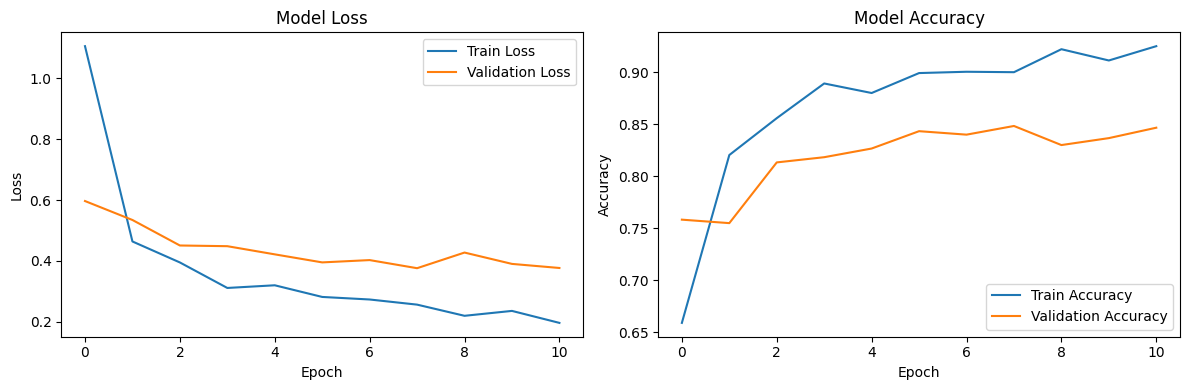

In [ ]:


print(f"Test Loss: {scores[0]}")
print(f"Test Accuracy: {scores[1]}")

# Performans metriklerini (loss ve accuracy) çizdirmek için
plt.figure(figsize=(12, 4))

# Loss grafiği
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

# Accuracy grafiği
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

DENSENET MODELI

In [ ]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import optuna

def create_densenet_model(params):
    base_model = DenseNet121(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)

    # Dinamik olarak yoğun katmanlar ekleyin Bu döngü, kullanıcının belirlediği sayıda yoğun (Dense) katmanı modele ekler.
    for i in range(params.get('n_layers', 1)): # Yoğun katmanların sayısını belirler; eğer belirtilmezse varsayılan olarak 1 katman eklenir.
        units_key = f'units_{i}'
        x = Dense(params.get(units_key, 256), activation='relu')(x)  # Varsayılan birim sayısı 256

    #Bu katman, aşırı öğrenmeyi (overfitting) önlemek amacıyla rastgele nöronları devre dışı bırakır. Varsayılan oran %50'dir.
    x = Dropout(params.get('dropout_rate', 0.5))(x)  # Varsayılan dropout oranı 0.5
    predictions = Dense(3, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer=Adam(learning_rate=params.get('learning_rate', 1e-3)),  # Varsayılan öğrenme oranı 1e-3
                  loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [ ]:
class TimeHistory(Callback):
    def on_train_begin(self, logs=None):
        self.times = []  # Her epoch için süreleri saklar
        self.total_time = 0  # Toplam süreyi saklar
        self.start_time = time.time()  # Eğitim başlangıç zamanı

    def on_epoch_begin(self, epoch, logs=None):
        self.epoch_start_time = time.time()  # Epoch başlangıç zamanı

    def on_epoch_end(self, epoch, logs=None):
        epoch_time = time.time() - self.epoch_start_time
        self.times.append(epoch_time)
        self.total_time += epoch_time  # Toplam süreye ekler
        print(f"Epoch {epoch + 1} ---- {int(epoch_time // 60)} dakika {int(epoch_time % 60)} saniye")

    def on_train_end(self, logs=None):
        # Eğitim sonunda toplam süreyi yazdır
        total_minutes = int(self.total_time // 60)
        total_seconds = int(self.total_time % 60)
        print(f"Toplam Eğitim Süresi: {total_minutes} dakika {total_seconds} saniye")


def objective(trial):
    model = create_model(trial)
    train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True,
                                       validation_split=0.2) # %20 doğrulama için ayrılıyor

    # Eğitim ve doğrulama veri setleri
    train_generator = train_datagen.flow_from_directory(
        train_folder,
        target_size=(64, 64),
        batch_size=32,
        class_mode='categorical',
        subset='training'
    )

    validation_generator = train_datagen.flow_from_directory(
        train_folder,
        target_size=(64, 64),
        batch_size=32,
        class_mode='categorical',
        subset='validation'
    )
     # Model oluşturulduktan sonra derleme işlemi
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Early stopping ve zaman takibi callback'leri
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)
    time_history = TimeHistory()

    # Model eğitimi
    history = model.fit(
        train_generator,
        epochs=50,
        validation_data=validation_generator,
        callbacks=[early_stopping, time_history],
        verbose=0
    )

    # En iyi epoch ve doğruluk bilgisini döndür
    best_epoch = early_stopping.stopped_epoch - 2  # Early stopping 2 sabrından dolayı
    print(f"En iyi epoch: {best_epoch + 1} ile en iyi doğruluk.")
    validation_accuracy = history.history['val_accuracy'][best_epoch]
    return validation_accuracy

# Optuna çalıştırma
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=2)

# En iyi parametrelerin yazdırılması
print("En iyi parametreler:", study.best_trial.params)


[I 2024-05-06 09:11:45,670] A new study created in memory with name: no-name-0ad8cd0d-2422-4bb8-988f-d01a14cb3b21


Found 2400 images belonging to 3 classes.
Found 600 images belonging to 3 classes.
Epoch 1 ---- 1 dakika 17 saniye
Epoch 2 ---- 1 dakika 0 saniye
Epoch 3 ---- 0 dakika 51 saniye
Epoch 4 ---- 1 dakika 2 saniye
Epoch 5 ---- 0 dakika 50 saniye
Epoch 6 ---- 0 dakika 51 saniye
Epoch 7 ---- 0 dakika 49 saniye
Restoring model weights from the end of the best epoch: 5.
Epoch 8 ---- 0 dakika 53 saniye
Epoch 8: early stopping


[I 2024-05-06 09:20:39,830] Trial 0 finished with value: 0.9350000023841858 and parameters: {'units': 128}. Best is trial 0 with value: 0.9350000023841858.


Toplam Eğitim Süresi: 7 dakika 37 saniye
En iyi epoch: 6 ile en iyi doğruluk.
Found 2400 images belonging to 3 classes.
Found 600 images belonging to 3 classes.
Epoch 1 ---- 1 dakika 2 saniye
Epoch 2 ---- 0 dakika 59 saniye
Epoch 3 ---- 0 dakika 52 saniye
Epoch 4 ---- 0 dakika 49 saniye
Epoch 5 ---- 0 dakika 49 saniye
Epoch 6 ---- 1 dakika 3 saniye
Epoch 7 ---- 1 dakika 1 saniye
Restoring model weights from the end of the best epoch: 5.
Epoch 8 ---- 0 dakika 52 saniye
Epoch 8: early stopping


[I 2024-05-06 09:31:18,991] Trial 1 finished with value: 0.9333333373069763 and parameters: {'units': 256}. Best is trial 0 with value: 0.9350000023841858.


Toplam Eğitim Süresi: 7 dakika 31 saniye
En iyi epoch: 6 ile en iyi doğruluk.
En iyi parametreler: {'units': 128}


In [ ]:

def create_densenet_model_from_best_params(params):
    base_model = DenseNet121(include_top=False, weights='imagenet', input_shape=(224, 224, 3))  # ImageNet ağırlıkları ile
    x = base_model.output
    x = GlobalAveragePooling2D()(x)

    for i in range(params['n_layers']):
        units_key = f'units_{i}'
        if units_key in params:
            x = Dense(params[units_key], activation='relu')(x)

    predictions = Dense(3, activation='softmax')(x)  # 3 sınıf çıkış katmanı

    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer=Adam(learning_rate=params.get('learning_rate', 1e-3)), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:

# En iyi parametrelerle DenseNet modelini oluştur
best_params = study.best_trial.params
best_densenet_model = create_densenet_model(best_params)

# ImageDataGenerator'ı doğrulama seti ile birlikte kullanmak için ayarla
data_gen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True, validation_split=0.2)

# Eğitim ve doğrulama veri setlerini yükle
train_generator = data_gen.flow_from_directory(
    train_folder,
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = data_gen.flow_from_directory(
    train_folder,
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

# Modeli eğit
history = best_densenet_model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    callbacks=[early_stopping],
    verbose=1
)

# Eğitimin Tamamlanması ve Doğruluk Skorunun Yazdırılması
print(f"Training completed with final accuracy: {history.history['accuracy'][-1]}")

# Test Veri Setini Hazırlama
test_datagen = ImageDataGenerator(rescale=1./255)
test_set = test_datagen.flow_from_directory(
    test_folder,
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Tahmin sırasının karışmaması için
)

# Test Verileri Üzerinde Modelin Değerlendirilmesi
scores = best_densenet_model.evaluate(test_set, verbose=1)
print(f"Test doğruluğu: {scores[1]}")

Found 2400 images belonging to 3 classes.
Found 600 images belonging to 3 classes.
Epoch 1/50
75/75 [==============================] - 208s 2s/step - loss: 0.5728 - accuracy: 0.8154 - val_loss: 2.4790 - val_accuracy: 0.8317
Epoch 2/50
75/75 [==============================] - 162s 2s/step - loss: 0.2080 - accuracy: 0.9279 - val_loss: 3.8674 - val_accuracy: 0.8233
Epoch 3/50
75/75 [==============================] - 152s 2s/step - loss: 0.1977 - accuracy: 0.9337 - val_loss: 0.8116 - val_accuracy: 0.8750
Epoch 4/50
75/75 [==============================] - 161s 2s/step - loss: 0.1677 - accuracy: 0.9438 - val_loss: 0.2724 - val_accuracy: 0.9150
Epoch 5/50
75/75 [==============================] - 166s 2s/step - loss: 0.1535 - accuracy: 0.9463 - val_loss: 0.2567 - val_accuracy: 0.9167
Epoch 6/50
75/75 [==============================] - 162s 2s/step - loss: 0.1176 - accuracy: 0.9646 - val_loss: 2.7988 - val_accuracy: 0.7250
Epoch 7/50
75/75 [==============================] - 162s 2s/step - loss

In [ ]:

from tensorflow.keras.utils import to_categorical
# Test Verileri Üzerinde Tahmin Yapma
y_pred = best_densenet_model.predict(test_set)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_set.classes

# Karışıklık Matrisi
conf_matrix = confusion_matrix(y_true, y_pred_classes)
print("Confusion Matrix:")
print(conf_matrix)

# Sınıflandırma Raporu
class_names = list(test_set.class_indices.keys())
class_report = classification_report(y_true, y_pred_classes, target_names=class_names)
print("Classification Report:")
print(class_report)

# Performans Metriklerinin Hesaplanması
roc_auc = roc_auc_score(to_categorical(y_true), y_pred, average='macro')
precision = precision_score(y_true, y_pred_classes, average='macro')
recall = recall_score(y_true, y_pred_classes, average='macro')
f1 = f1_score(y_true, y_pred_classes, average='macro')

print(f"ROC AUC Score: {roc_auc}")
print(f"Precision Score: {precision}")
print(f"Recall Score: {recall}")
print(f"F1 Score: {f1}")

19/19 [==============================] - 13s 537ms/step
Confusion Matrix:
[[116   5  68]
 [  2 173  18]
 [  1   0 199]]
Classification Report:
              precision    recall  f1-score   support

   airplanes       0.97      0.61      0.75       189
        cars       0.97      0.90      0.93       193
       ships       0.70      0.99      0.82       200

    accuracy                           0.84       582
   macro avg       0.88      0.84      0.84       582
weighted avg       0.88      0.84      0.84       582

ROC AUC Score: 0.9817912675236027
Precision Score: 0.8816485474536749
Recall Score: 0.8350432235838108
F1 Score: 0.8354932884012829


Test Loss: 0.7763140797615051
Test Accuracy: 0.838487982749939


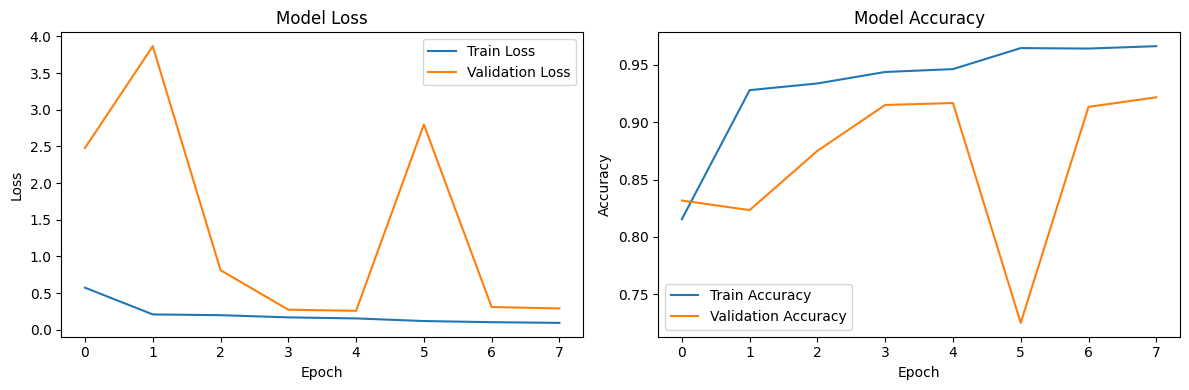

In [ ]:

print(f"Test Loss: {scores[0]}")
print(f"Test Accuracy: {scores[1]}")

# Performans metriklerini (loss ve accuracy) çizdirmek için
plt.figure(figsize=(12, 4))

# Loss grafiği
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

# Accuracy grafiği
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

ALEXNET

In [ ]:
def create_alexnet_model(trial):
    # Hiperparametre seçimi
    num_units = trial.suggest_categorical('units', [256, 512, 1024])
    dropout_rate = trial.suggest_float('dropout_rate', 0.2, 0.5)
    optimizer = trial.suggest_categorical('optimizer', ['adam', 'sgd'])
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-3, log=True)

    # AlexNet benzeri model yapısı
    model = Sequential([
        Conv2D(96, kernel_size=11, strides=4, activation='relu', input_shape=(227, 227, 3)),
        MaxPooling2D(pool_size=3, strides=2),
        Conv2D(256, kernel_size=5, padding='same', activation='relu'),
        MaxPooling2D(pool_size=3, strides=2),
        Conv2D(384, kernel_size=3, padding='same', activation='relu'),
        Conv2D(384, kernel_size=3, padding='same', activation='relu'),
        Conv2D(256, kernel_size=3, padding='same', activation='relu'),
        MaxPooling2D(pool_size=3, strides=2),
        Flatten(),
        Dense(4096, activation='relu'),
        Dropout(dropout_rate),
        Dense(4096, activation='relu'),
        Dropout(dropout_rate),
        Dense(num_units, activation='relu'),
        Dense(3, activation='softmax')
    ])

    # Modelin derlenmesi
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model


In [ ]:
class TimeHistory(Callback):
    def on_train_begin(self, logs=None):
        self.times = []
        self.total_time = 0
        self.start_time = time.time()

    def on_epoch_begin(self, epoch, logs=None):
        self.epoch_start_time = time.time()

    def on_epoch_end(self, epoch, logs=None):
        epoch_time = time.time() - self.epoch_start_time
        self.times.append(epoch_time)
        self.total_time += epoch_time
        print(f"Epoch {epoch + 1} ---- {int(epoch_time // 60)} dakika {int(epoch_time % 60)} saniye")

    def on_train_end(self, logs=None):
        total_minutes = int(self.total_time // 60)
        total_seconds = int(self.total_time % 60)
        print(f"Toplam Eğitim Süresi: {total_minutes} dakika {total_seconds} saniye")

def objective(trial):
    model = create_alexnet_model(trial)
    train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True, validation_split=0.2)
    train_generator = train_datagen.flow_from_directory(
        train_folder,
        target_size=(227, 227),
        batch_size=32,
        class_mode='categorical',
        subset='training'
    )
    validation_generator = train_datagen.flow_from_directory(
        train_folder,
        target_size=(227, 227),
        batch_size=32,
        class_mode='categorical',
        subset='validation'
    )
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)
    time_history = TimeHistory()
    history = model.fit(
        train_generator,
        epochs=50,
        validation_data=validation_generator,
        callbacks=[early_stopping, time_history], verbose=1)
    best_epoch = early_stopping.stopped_epoch - 2if early_stopping.stopped_epoch > 2 else early_stopping.stopped_epoch
    print(f"En iyi epoch: {best_epoch + 1} ile en iyi doğruluk: {max(history.history['val_accuracy'])}")
    return max(history.history['val_accuracy'])

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=2)
print("En iyi parametreler:", study.best_trial.params)

[I 2024-05-05 18:19:40,498] A new study created in memory with name: no-name-b2e50247-21ff-4391-8ce0-bb6565f52de1


Found 2400 images belonging to 3 classes.
Found 600 images belonging to 3 classes.
Epoch 1/50
75/75 [==============================] - 565s 7s/step - loss: 0.9592 - accuracy: 0.5113 - val_loss: 0.7897 - val_accuracy: 0.6567
Epoch 2/50
75/75 [==============================] - 569s 8s/step - loss: 0.6780 - accuracy: 0.7192 - val_loss: 0.8208 - val_accuracy: 0.6767
Epoch 3/50
75/75 [==============================] - 547s 7s/step - loss: 0.6031 - accuracy: 0.7517 - val_loss: 0.7420 - val_accuracy: 0.6883
Epoch 4/50
75/75 [==============================] - 554s 7s/step - loss: 0.5863 - accuracy: 0.7658 - val_loss: 0.5748 - val_accuracy: 0.7750
Epoch 5/50
75/75 [==============================] - 561s 7s/step - loss: 0.4409 - accuracy: 0.8358 - val_loss: 0.4784 - val_accuracy: 0.8150
Epoch 6/50
75/75 [==============================] - 625s 8s/step - loss: 0.3941 - accuracy: 0.8500 - val_loss: 0.3839 - val_accuracy: 0.8600
Epoch 7/50
75/75 [==============================] - 575s 8s/step - loss

[I 2024-05-05 20:13:54,754] Trial 0 finished with value: 0.8766666650772095 and parameters: {'units': 256, 'dropout_rate': 0.3947013957373268, 'optimizer': 'sgd', 'learning_rate': 0.00014104850437949266}. Best is trial 0 with value: 0.8766666650772095.


Toplam Eğitim Süresi: 114 dakika 3 saniye
En iyi epoch: 10 ile en iyi doğruluk: 0.8766666650772095
Found 2400 images belonging to 3 classes.
Found 600 images belonging to 3 classes.
Epoch 1/50
75/75 [==============================] - 570s 8s/step - loss: 0.8623 - accuracy: 0.5362 - val_loss: 0.7805 - val_accuracy: 0.6150
Epoch 2/50
75/75 [==============================] - 553s 7s/step - loss: 0.6930 - accuracy: 0.7083 - val_loss: 0.7040 - val_accuracy: 0.7000
Epoch 3/50
75/75 [==============================] - 568s 8s/step - loss: 0.5854 - accuracy: 0.7592 - val_loss: 0.5724 - val_accuracy: 0.7567
Epoch 4/50
75/75 [==============================] - 551s 7s/step - loss: 0.5054 - accuracy: 0.8050 - val_loss: 0.6742 - val_accuracy: 0.7333
Epoch 5/50
75/75 [==============================] - 564s 8s/step - loss: 0.4684 - accuracy: 0.8225 - val_loss: 0.5237 - val_accuracy: 0.7767
Epoch 6/50
75/75 [==============================] - 561s 7s/step - loss: 0.3609 - accuracy: 0.8642 - val_loss: 0.

[I 2024-05-05 22:55:21,400] Trial 1 finished with value: 0.9266666769981384 and parameters: {'units': 512, 'dropout_rate': 0.35610107955194303, 'optimizer': 'adam', 'learning_rate': 0.00017363978160380835}. Best is trial 1 with value: 0.9266666769981384.


Toplam Eğitim Süresi: 160 dakika 28 saniye
En iyi epoch: 15 ile en iyi doğruluk: 0.9266666769981384
En iyi parametreler: {'units': 512, 'dropout_rate': 0.35610107955194303, 'optimizer': 'adam', 'learning_rate': 0.00017363978160380835}


In [ ]:


def create_alexnet_model_from_best_params(params):
    # AlexNet benzeri bir model yapısı kuruyoruz.
    model = Sequential([
        Conv2D(params.get('filters_first', 96), kernel_size=11, strides=4, activation='relu', input_shape=(227, 227, 3)),
        MaxPooling2D(pool_size=3, strides=2),
        Conv2D(params.get('filters_second', 256), kernel_size=5, padding='same', activation='relu'),
        MaxPooling2D(pool_size=3, strides=2),
        Conv2D(params.get('filters_third', 384), kernel_size=3, padding='same', activation='relu'),
        Conv2D(params.get('filters_fourth', 384), kernel_size=3, padding='same', activation='relu'),
        Conv2D(params.get('filters_fifth', 256), kernel_size=3, padding='same', activation='relu'),
        MaxPooling2D(pool_size=3, strides=2),
        Flatten(),
        Dense(params.get('dense_units_1', 4096), activation='relu'),
        Dropout(params.get('dropout_1', 0.5)),
        Dense(params.get('dense_units_2', 4096), activation='relu'),
        Dropout(params.get('dropout_2', 0.5)),
        Dense(params.get('final_units', 3), activation='softmax')  # 3 sınıf varsayımı
    ])

    # Öğrenme oranını Optuna tarafından belirlenen değerle ayarla
    learning_rate = params.get('learning_rate', 1e-4)  # Varsayılan değer olarak 0.0001 kullanılır

    # Modelin derlenmesi
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model


In [ ]:
# En İyi Parametrelerle AlexNet Modelini Oluşturma
best_params = study.best_trial.params
best_alexnet_model = create_alexnet_model_from_best_params(best_params)

# ImageDataGenerator'ı doğrulama seti ile birlikte kullanmak için ayarla
data_gen = ImageDataGenerator(rescale=1./255,
                              shear_range=0.2,
                              zoom_range=0.2,
                              horizontal_flip=True,
                              validation_split=0.2)  # Doğrulama için %20 ayır

# Eğitim ve doğrulama veri setlerini yükle
train_generator = data_gen.flow_from_directory(
    train_folder,
    target_size=(227, 227),
    batch_size=32,
    class_mode='categorical',
    subset='training')  # Eğitim seti için

validation_generator = data_gen.flow_from_directory(
    train_folder,
    target_size=(227, 227),
    batch_size=32,
    class_mode='categorical',
    subset='validation')  # Doğrulama seti için

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

# Modeli eğitim ve doğrulama veri setleri ile eğit
history = best_alexnet_model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    callbacks=[early_stopping],
    verbose=1
)

# Early stopping'den sonra en iyi epochu bulma
best_epoch = np.argmax(history.history['val_accuracy']) + 1
best_val_accuracy = max(history.history['val_accuracy'])

print(f"En iyi epoch: {best_epoch}, En iyi doğruluk: {best_val_accuracy}")

# Eğitimin Tamamlanması ve Doğruluk Skorunun Yazdırılması
print(f"Eğitim tamamlandı. Son doğruluk: {history.history['accuracy'][-1]}")

# Test Veri Setini Hazırlama
test_datagen = ImageDataGenerator(rescale=1./255)
test_set = test_datagen.flow_from_directory(
    test_folder,
    target_size=(227, 227),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Tahmin sırasının karışmaması için
)

# Test Verileri Üzerinde Modelin Değerlendirilmesi
scores = best_alexnet_model.evaluate(test_set, verbose=1)
print(f"Test doğruluğu: {scores[1]}")


Found 2400 images belonging to 3 classes.
Found 600 images belonging to 3 classes.
Epoch 1/50
75/75 [==============================] - 558s 7s/step - loss: 0.9918 - accuracy: 0.4792 - val_loss: 0.7698 - val_accuracy: 0.6500
Epoch 2/50
75/75 [==============================] - 579s 8s/step - loss: 0.6917 - accuracy: 0.6921 - val_loss: 0.6791 - val_accuracy: 0.6750
Epoch 3/50
75/75 [==============================] - 558s 7s/step - loss: 0.6048 - accuracy: 0.7554 - val_loss: 0.6275 - val_accuracy: 0.7583
Epoch 4/50
75/75 [==============================] - 554s 7s/step - loss: 0.5265 - accuracy: 0.8000 - val_loss: 0.5774 - val_accuracy: 0.7600
Epoch 5/50
75/75 [==============================] - 565s 8s/step - loss: 0.4191 - accuracy: 0.8442 - val_loss: 0.5546 - val_accuracy: 0.7917
Epoch 6/50
75/75 [==============================] - 555s 7s/step - loss: 0.4092 - accuracy: 0.8458 - val_loss: 0.4673 - val_accuracy: 0.8133
Epoch 7/50
75/75 [==============================] - 566s 8s/step - loss

In [ ]:

# Test Verileri Üzerinde Tahmin Yapma
y_pred = best_alexnet_model.predict(test_set)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_set.classes

# Karışıklık Matrisi
conf_matrix = confusion_matrix(y_true, y_pred_classes)
print("Confusion Matrix:")
print(conf_matrix)

# Sınıflandırma Raporu
class_names = list(test_set.class_indices.keys())
class_report = classification_report(y_true, y_pred_classes, target_names=class_names)
print("Classification Report:")
print(class_report)

# Performans Metriklerinin Hesaplanması
roc_auc = roc_auc_score(to_categorical(y_true), y_pred, average='macro')
precision = precision_score(y_true, y_pred_classes, average='macro')
recall = recall_score(y_true, y_pred_classes, average='macro')
f1 = f1_score(y_true, y_pred_classes, average='macro')

print(f"ROC AUC Score: {roc_auc}")
print(f"Precision Score: {precision}")
print(f"Recall Score: {recall}")
print(f"F1 Score: {f1}")

19/19 [==============================] - 33s 2s/step
Confusion Matrix:
[[160  18  11]
 [  0 190   3]
 [  2   3 195]]
Classification Report:
              precision    recall  f1-score   support

   airplanes       0.99      0.85      0.91       189
        cars       0.90      0.98      0.94       193
       ships       0.93      0.97      0.95       200

    accuracy                           0.94       582
   macro avg       0.94      0.94      0.94       582
weighted avg       0.94      0.94      0.94       582

ROC AUC Score: 0.9950221430761118
Precision Score: 0.9403808695679764
Recall Score: 0.9353389350366897
F1 Score: 0.9352734011202303


Test Loss: 0.20416732132434845
Test Accuracy: 0.9364261031150818


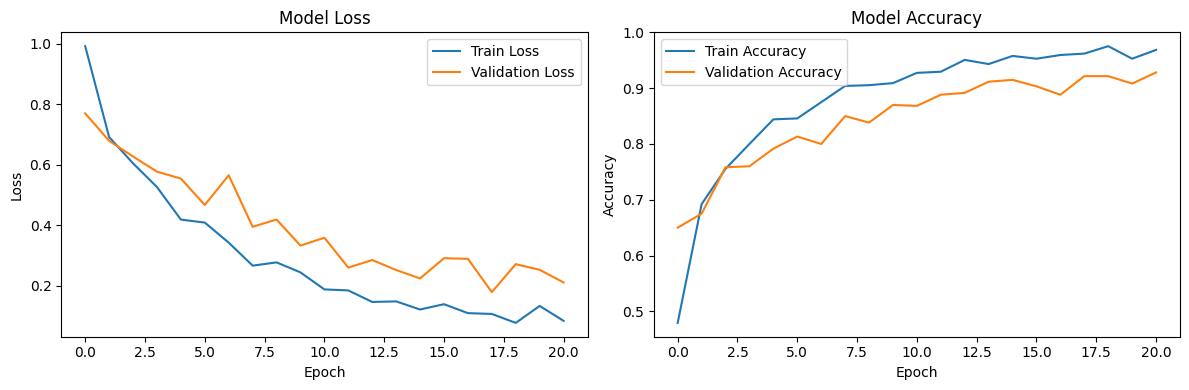

In [ ]:
#ALEXNET MODELI

print(f"Test Loss: {scores[0]}")
print(f"Test Accuracy: {scores[1]}")

# Performans metriklerini (loss ve accuracy) çizdirmek için
plt.figure(figsize=(12, 4))

# Loss grafiği
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

# Accuracy grafiği
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
